In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import ast 

import warnings 
warnings.filterwarnings('ignore')

PATH_TO_DATA = '/home/lgierz/BA_MothClassification/data/'
PATH_TO_CA = PATH_TO_DATA + 'confidence_analysis/'

model_names = ["Linear Classifier", "KNN"]
fm_names = ['resnet', 'dino']

dataset_configs = {
    'top277': (277, [3000, 2000, 1000, 500]),
    'top387': (387, [2000, 1000, 500]),
    'top589': (589, [1000, 500])
}


PATH_TO_IMAGES = '/mnt/data/lgierz/moth_dataset_top589_max3000/'
PATH_TO_LABELS = PATH_TO_DATA + 'processed/dataset_top589_max3000.csv'
PATH_TO_CORRECTED_CONFS = PATH_TO_CA + 'results/all_results_corrected_labels_w_scores_w_gaps.csv'


In [2]:
labels_csv = pd.read_csv(PATH_TO_LABELS)
confidences_csv = pd.read_csv(PATH_TO_CORRECTED_CONFS)

# create real mapping for labels_csv
species = labels_csv['scientificName']
unique_species = sorted(species.unique())
species_mapping = {species: idx for idx, species in enumerate(unique_species)}

print(unique_species)
print(species_mapping)
print(len(unique_species))

['Abraxas grossulariata', 'Abraxas sylvata', 'Abrostola triplasia', 'Acasis viretata', 'Acentria ephemerella', 'Acleris forsskaleana', 'Acleris notana/ferrugana', 'Acleris variegana', 'Acontia lucida', 'Acontia trabealis', 'Acrobasis advenella', 'Acrobasis repandana', 'Acrobasis tumidana', 'Acronicta aceris', 'Acronicta leporina', 'Acronicta rumicis', 'Acronicta tridens / psi', 'Adela reaumurella', 'Adscita statices', 'Aethalura punctulata', 'Agapeta hamana', 'Agapeta zoegana', 'Aglais io', 'Aglais urticae', 'Aglossa pinguinalis', 'Agonopterix arenella', 'Agonopterix heracliana / ciliella', 'Agriopis aurantiaria', 'Agriopis leucophaearia', 'Agriopis marginaria', 'Agriphila geniculea', 'Agriphila inquinatella', 'Agriphila selasella', 'Agriphila straminella', 'Agriphila tristella', 'Agrius convolvuli', 'Agrochola circellaris', 'Agrochola lota', 'Agrochola lunosa', 'Agrochola lychnidis', 'Agrochola macilenta', 'Agrotis clavis', 'Agrotis exclamationis', 'Agrotis ipsilon', 'Agrotis puta', '

In [36]:
for s in unique_species:
    if s[-1] == '.':
        print(s)

Amphipoea spec.
Cnephasia spec.
Coleophora spec.
Crambidae indet.
Epirrita spec.
Eupithecia spec.
Idaea spec.
Oligia spec.
Parornix spec.
Pyrgus spec.
Yponomeuta spec.


In [3]:
# Check if any species names contain the string 'spec.'
contains_spec = [(spec, num) for spec, num in species_mapping.items() if 'spec.' in spec]
print(len(contains_spec), contains_spec)

10 [('Amphipoea spec.', 54), ('Cnephasia spec.', 148), ('Coleophora spec.', 152), ('Epirrita spec.', 230), ('Eupithecia spec.', 256), ('Idaea spec.', 330), ('Oligia spec.', 428), ('Parornix spec.', 453), ('Pyrgus spec.', 503), ('Yponomeuta spec.', 583)]


In [4]:
# check how many of those clusters exist
species_nums_in_spec_cluster = []
species_nums_spec = []

overall_count = 0
for (spec, num) in contains_spec:

    genus = spec.split(' ')[0]
    subspecies = [(name, num) for (name, num) in species_mapping.items() if genus in name]
    if len(subspecies) == 1:
        continue
    print(genus, len(subspecies), subspecies)
    overall_count += len(subspecies)
    species_nums_in_spec_cluster.extend([num for (_, num) in subspecies])
    species_nums_spec.append(num)
print(f'In total {overall_count} species belong to a cluster')
print(species_nums_in_spec_cluster)
print(species_nums_spec)


Eupithecia 10 [('Eupithecia abbreviata', 250), ('Eupithecia centaureata', 251), ('Eupithecia intricata', 252), ('Eupithecia inturbata', 253), ('Eupithecia nanata', 254), ('Eupithecia oxycedrata', 255), ('Eupithecia spec.', 256), ('Eupithecia tantillaria', 257), ('Eupithecia tripunctaria', 258), ('Eupithecia vulgata', 259)]
Idaea 11 [('Idaea aversata', 321), ('Idaea biselata', 322), ('Idaea degeneraria', 323), ('Idaea dimidiata', 324), ('Idaea emarginata', 325), ('Idaea fuscovenosa', 326), ('Idaea ochrata', 327), ('Idaea rusticata', 328), ('Idaea seriata', 329), ('Idaea spec.', 330), ('Idaea subsericeata', 331)]
Oligia 3 [('Oligia fasciuncula', 427), ('Oligia spec.', 428), ('Oligia strigilis', 429)]
Pyrgus 3 [('Pyrgus malvae', 501), ('Pyrgus malvoides', 502), ('Pyrgus spec.', 503)]
Yponomeuta 3 [('Yponomeuta evonymella', 581), ('Yponomeuta plumbella', 582), ('Yponomeuta spec.', 583)]
In total 30 species belong to a cluster
[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 321, 322, 323

In [5]:
all_geni = [spec.split(' ')[0] for spec in unique_species]
unique_geni = sorted(all_geni)
all_geni_series = pd.Series(all_geni)
value_counts = all_geni_series.value_counts()
groups_with_more_than_one = value_counts[value_counts > 1]
print(groups_with_more_than_one.sum())
genera_with_more_than_one = groups_with_more_than_one.keys()
numeric_mappings = [species_mapping[species] for species in unique_species if species.split(' ')[0] in genera_with_more_than_one]
# print(len(numeric_mappings), numeric_mappings)


288


### How much percent of wrong classification belong to a cluster? what could be the optimal accuracy with a better curated dataset? just leave out the 30

In [6]:

def show_sample_by_id(gbifid, conf_csv):

    # Find the image file
    image_files = glob.glob(PATH_TO_IMAGES + f"{gbifid}_*.jpg")
    if not image_files:
        print(f"No image found for GBIF ID {gbifid}")
        return
    
    image_path = image_files[0]
    image = plt.imread(image_path)

    info_text = ""

    rows = conf_csv[conf_csv['GbifID'] == gbifid]

    for idx, row in rows.iterrows():
    
        # serach in labels csv for the scientific name
        accuracy = row['Accuracy']
        species = row['Species']
        samples = row['Samples']
        fm = row['FoundationalModel']
        model = row['Model']
        species_num = row['Label']
        species_str = list(species_mapping.keys())[species_num]
        
        predicted_species_num = row['PredictedLabel']
        predicted_species_str = list(species_mapping.keys())[predicted_species_num]
        confidences = [(i,round(x, 4)) for i,x in eval(row['Confidence'])[0:5]]

        info_text += f"top{species}max{samples} / {fm.upper()}-{model} / Accuracy: {round(accuracy*100, 2)}%\n" \
            f"GbifID: {gbifid} | Filename: {image_path.split('/')[-1]}\n" \
            f"Labeled: {species_num}, {species_str}\n" \
            f"Predicted: {predicted_species_num}, {predicted_species_str}\n" \
            f"confidences: {confidences}\n\n"

        # print(f'Confidences for top{species}max{samples} / {fm.upper()}-{model}:')
        # print(confidences) 
    print(species_str, image_path.split('/')[-1])

    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off')  # Turn off the axis

    # Adding the text box
    props = dict(boxstyle='square', facecolor='lightblue', alpha=0.5)
    plt.text(1.03, 0.8, info_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=props)

    plt.show()
    plt.pause(0.001)  

def get_gbifids_for_class(class_num, conf_csv, count=5):
    return list(conf_csv[conf_csv['Label'] == class_num]['GbifID'].head(count))




In [7]:
confidences_csv.head(3)

,Species,Samples,FoundationalModel,Model,Training Time (s),Accuracy,Precision,Recall,F1-Score,GbifID,Label,PredictedLabel,Confidence,Top1_Confidence,Top2_Confidence,Confidence_Gap,Correct
0,277,3000,resnet,Linear Classifier,107.1,0.7029,0.7021,0.7029,0.7018,3732729294,2,481,"[(481, 0.5848367), (78, 0.0888306), (12, 0.053...",0.584837,0.088831,0.496006,False
1,277,3000,resnet,Linear Classifier,107.1,0.7029,0.7021,0.7029,0.7018,3726074650,2,2,"[(2, 0.877642), (577, 0.031730235), (90, 0.023...",0.877642,0.031730,0.845912,True
2,277,3000,resnet,Linear Classifier,107.1,0.7029,0.7021,0.7029,0.7018,3722145058,2,2,"[(2, 0.965016), (415, 0.015936695), (185, 0.00...",0.965016,0.015937,0.949079,True


In [8]:
def round_to_0_or_5(number, decimals=3):
    factor = 10 ** decimals
    rounded = round(number * factor)  # Round to the nearest integer at given precision
    remainder = rounded % 10
    
    # Adjust to the nearest multiple of 5 or 0
    if remainder < 3:
        rounded -= remainder  # Round down to 0
    elif remainder < 8:
        rounded += (5 - remainder)  # Round to 5
    else:
        rounded += (10 - remainder)  # Round up to 0
    
    return rounded / factor

# Example usage
# print(round_to_0_or_5(0.43253253))  # Output: 0.430
# print(round_to_0_or_5(0.3567))      # Output: 0.355
# print(round_to_0_or_5(0.3597))      # Output: 0.355


In [9]:

def create_label_overview(fm, clf, species, samples):
    filtered_df_dino = confidences_csv[(confidences_csv['FoundationalModel'] == fm) & (confidences_csv['Model'] == clf)]
    filtered_df_dino_specific_ds = filtered_df_dino[(filtered_df_dino['Species'] == species) & (filtered_df_dino['Samples'] == samples)]

    # create class accuracy
    filtered_df_dino_specific_ds['Correct'] = filtered_df_dino_specific_ds['Correct'].astype(bool)
    filtered_df_dino_specific_ds['ClassAccuracy'] = filtered_df_dino_specific_ds.groupby('Label')['Correct'].transform('mean').round(3).apply(lambda x: round_to_0_or_5(x))

    # add label names
    filtered_df_dino_specific_ds['LabelName'] = filtered_df_dino_specific_ds['Label'].apply(lambda label: list(species_mapping.keys())[label])
    
    #add per class average confidence
    filtered_df_dino_specific_ds['AverageTop1Confidence'] = filtered_df_dino_specific_ds.groupby('Label')['Top1_Confidence'].transform('mean').round(4)
    filtered_df_dino_specific_ds['AverageTop1ConfidenceCorrect'] = filtered_df_dino_specific_ds.groupby('Label')['Top1_Confidence'].transform(lambda x: x[filtered_df_dino_specific_ds['Correct']].mean()).round(4)
    filtered_df_dino_specific_ds['AverageTop1ConfidenceIncorrect'] = filtered_df_dino_specific_ds.groupby('Label')['Top1_Confidence'].transform(lambda x: x[~filtered_df_dino_specific_ds['Correct']].mean()).round(4)


    # create classification counts
    classification_counts = filtered_df_dino_specific_ds.groupby('Label')['PredictedLabel'].value_counts()
    top2_classification_counts = classification_counts[classification_counts > 1]
    classification_counts_tuples = top2_classification_counts.reset_index().groupby('Label').apply(lambda x: str(list(x[['PredictedLabel', 'count']].itertuples(index=False, name=None))))
    filtered_df_dino_specific_ds['ClassificationCounts'] = filtered_df_dino_specific_ds['Label'].apply(lambda label: classification_counts_tuples[label] if label in classification_counts_tuples else [])

    all_geni = [spec.split(' ')[0] for spec in filtered_df_dino_specific_ds['LabelName'].unique()]
    groups_with_more_than_one = pd.Series(all_geni).value_counts()[value_counts > 1]

    # Add ClusterSize column
    filtered_df_dino_specific_ds['ClusterSize'] = filtered_df_dino_specific_ds['LabelName'].apply(
        lambda label: groups_with_more_than_one[label.split(' ')[0]] if label.split(' ')[0] in groups_with_more_than_one else 1
    )


    label_overview_dino_linear_top589max1000 = filtered_df_dino_specific_ds[['Species','Samples','FoundationalModel', 'Model','Label', 'LabelName', 'ClassAccuracy', 'ClassificationCounts', 'ClusterSize', 'AverageTop1Confidence', 'AverageTop1ConfidenceCorrect', 'AverageTop1ConfidenceIncorrect']].drop_duplicates().reset_index(drop=True)
    return label_overview_dino_linear_top589max1000

df = create_label_overview('dino', 'Linear Classifier', 589, 1000)
df.shape
df.tail(10)

,Species,Samples,FoundationalModel,Model,Label,LabelName,ClassAccuracy,ClassificationCounts,ClusterSize,AverageTop1Confidence,AverageTop1ConfidenceCorrect,AverageTop1ConfidenceIncorrect
579,589,1000,dino,Linear Classifier,579,Xestia xanthographa,0.810,"[(579, 162), (195, 4), (115, 3), (434, 2), (57...",4,0.7084,0.7666,0.4606
580,589,1000,dino,Linear Classifier,580,Xylocampa areola,0.955,"[(580, 191), (59, 2), (87, 2)]",1,0.8907,0.9092,0.4993
581,589,1000,dino,Linear Classifier,581,Yponomeuta evonymella,0.890,"[(581, 178), (583, 15)]",3,0.8995,0.9251,0.6925
582,589,1000,dino,Linear Classifier,582,Yponomeuta plumbella,0.895,"[(582, 179), (583, 12), (83, 2), (371, 2)]",3,0.9087,0.9336,0.6958
583,589,1000,dino,Linear Classifier,583,Yponomeuta spec.,0.865,"[(583, 173), (581, 17), (582, 4)]",3,0.8423,0.8737,0.6405
584,589,1000,dino,Linear Classifier,584,Ypsolopha scabrella,0.960,"[(584, 192)]",1,0.9639,0.9803,0.5701
585,589,1000,dino,Linear Classifier,585,Zeiraphera isertana,0.910,"[(585, 182), (244, 3), (130, 2), (78, 2)]",1,0.8918,0.9128,0.6799
586,589,1000,dino,Linear Classifier,586,Zerynthia rumina,0.895,"[(586, 179), (242, 3), (387, 2), (503, 2), (95...",1,0.9131,0.9511,0.5894
587,589,1000,dino,Linear Classifier,587,Zeuzera pyrina,0.970,"[(587, 194)]",1,0.9784,0.9922,0.5330
588,589,1000,dino,Linear Classifier,588,Zygaena filipendulae,0.950,"[(588, 190), (500, 2), (18, 2)]",1,0.9321,0.9494,0.6038


In [10]:
df = create_label_overview('dino', 'Linear Classifier', 277, 1000)

def get_labels_by_accuracy(df, cluster_size):
    # Filter the dataframe by cluster size
    filtered_df = df[df['ClusterSize'] == cluster_size]
    
    # Sort the dataframe by class accuracy
    sorted_df = filtered_df.sort_values(by='ClassAccuracy')
    
    # Split the sorted dataframe into thirds
    total_count = len(sorted_df)
    lower_third = sorted_df.iloc[:total_count // 3]['Label'].tolist()
    middle_third = sorted_df.iloc[total_count // 3: 2 * total_count // 3]['Label'].tolist()
    upper_third = sorted_df.iloc[2 * total_count // 3:]['Label'].tolist()
    
    return lower_third, middle_third, upper_third

# Create a dictionary to store the results
cluster_size_dict = {}

# Iterate over cluster sizes from 1 to 6 and get the labels
for cluster_size in range(1, 7):
    lower, middle, upper = get_labels_by_accuracy(df, cluster_size)
    cluster_size_dict[cluster_size] = {
        'lower_third': lower,
        'middle_third': middle,
        'upper_third': upper
    }

print(cluster_size_dict)


{1: {'lower_third': [486, 84, 380, 422, 335, 478, 506, 100, 177, 284, 343, 485, 128, 339, 450, 389, 491, 236, 119, 528, 241, 153, 390, 90, 117, 82, 420, 63, 59, 376, 110, 304, 307, 76, 222, 379, 360, 69, 488, 230, 163, 337, 274, 229, 120, 35, 537, 220, 113, 287, 449, 210, 247, 264, 73, 219, 195], 'middle_third': [2, 64, 93, 105, 532, 448, 141, 443, 458, 334, 561, 454, 350, 370, 412, 430, 207, 480, 431, 136, 404, 471, 196, 468, 317, 223, 563, 396, 509, 508, 174, 197, 483, 205, 192, 91, 538, 102, 109, 381, 558, 88, 231, 155, 319, 296, 157, 461, 51, 173, 48, 432, 70, 497, 366, 355, 469], 'upper_third': [118, 156, 72, 514, 470, 556, 495, 481, 289, 424, 12, 17, 134, 171, 182, 237, 260, 139, 50, 536, 414, 121, 309, 138, 206, 494, 201, 344, 392, 58, 112, 559, 426, 393, 439, 225, 456, 567, 464, 300, 543, 560, 194, 221, 4, 20, 65, 551, 459, 89, 507, 203, 340, 79, 493, 588, 490, 53]}, 2: {'lower_third': [368, 554, 553, 369, 362, 361, 311, 23, 566, 104, 579, 22, 498, 151, 499, 144, 116, 373, 150,

In [40]:
from matplotlib.lines import Line2D

observed_classes = [528, 34, 212, 473]  # classes with the biggest change in class accuracy between dataset variants for dino linear classifier runs

# Add the numbers as text to the scatter dots


def scatter_labels(df_vis):
    # Create a dictionary to map species names to their indices
    species_to_index = {species: idx for idx, species in enumerate(df_vis['Label'])}

    # Define colors based on conditions
    df_vis['color'] = ['blue' if label in species_nums_spec else 
                       'cyan' if label in species_nums_in_spec_cluster else 
                       'magenta' if label in observed_classes else
                       'red' if label in [item for sublist in [cluster_size_dict[x]['lower_third'] for x in range(1, 7)] for item in sublist] else  # low acc
                       'orange' if label in [item for sublist in [cluster_size_dict[x]['middle_third'] for x in range(1, 7)] for item in sublist] else  # medium acc
                       'green' if label in [item for sublist in [cluster_size_dict[x]['upper_third'] for x in range(1, 7)] for item in sublist] else  # high acc
                       'black' for label in df_vis['Label']]
    
    df_vis['size'] = [30 if label in species_nums_spec else 
                      15 if label in species_nums_in_spec_cluster else 
                      30 if label in observed_classes else
                      10 if label in [item for sublist in [cluster_size_dict[x]['lower_third'] for x in range(1, 7)] for item in sublist] else  # low acc
                      10 if label in [item for sublist in [cluster_size_dict[x]['middle_third'] for x in range(1, 7)] for item in sublist] else  # medium acc
                      10 if label in [item for sublist in [cluster_size_dict[x]['upper_third'] for x in range(1, 7)] for item in sublist] else
                      10 for label in df_vis['Label']]

    # Create a dictionary to track the number of points at each (x, y) position
    position_counts = {}

    # Calculate the offsets
    offsets = []
    for x, y in zip(df_vis['ClassAccuracy'] * 100, df_vis['ClusterSize']):
        if (x, y) not in position_counts:
            position_counts[(x, y)] = 0
        else:
            position_counts[(x, y)] += 1
        offsets.append(position_counts[(x, y)])

    # Custom transformation for the y-axis
    def custom_transform(y):
        return np.where(y > 1, y + 3, y)

    # Scatter plot of Class Accuracy vs Cluster Size
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(df_vis['ClassAccuracy'] * 100, 
                          custom_transform(df_vis['ClusterSize']) + np.array(offsets) * 0.15, 
                          alpha=1, edgecolors='w', linewidth=0.5, marker='o', s=df_vis['size'], c=df_vis['color'])
    
    
    for i, row in df_vis[df_vis['Label'].isin(observed_classes)].iterrows():
        plt.text(row['ClassAccuracy'] * 100, custom_transform(row['ClusterSize'])- 0.5, str(row['Label']), fontsize=8, ha='right', color='magenta')


    # Calculate the average class accuracy for cluster sizes 1-6
    avg_class_accuracy = df_vis.groupby('ClusterSize')['ClassAccuracy'].mean() * 100
    print(avg_class_accuracy.round(2))
    print(round(avg_class_accuracy.max() - avg_class_accuracy.min(), 2))

    # Plot the average class accuracy for cluster sizes 1-6 as a vertical line between the current cluster size and the next one
    for cluster_size, avg_accuracy in avg_class_accuracy.items():
        next_cluster_size = cluster_size + 1 if cluster_size < 12 else cluster_size
        plt.plot([avg_accuracy, avg_accuracy], [custom_transform(cluster_size), custom_transform(next_cluster_size)], color='gray', linestyle='--', linewidth=1)

    plt.xlabel('Class Accuracy (%)')
    plt.ylabel('Cluster Size')
    fm = 'DINOv2' if df_vis['FoundationalModel'].iloc[0] == 'dino' else 'ResNet-50'
    clf = 'Logistic Regression' if df_vis['Model'].iloc[0] == 'Linear Classifier' else 'KNN'
    plt.title(f"{df_vis['Species'].iloc[0]} Species, {df_vis['Samples'].iloc[0]} Samples, {fm}-based, {clf}")   

    # Custom y-ticks
    yticks = np.arange(1, 12)
    yticklabels = [1] + list(np.arange(2, 12))
    plt.yticks(custom_transform(yticks), yticklabels)
    plt.xticks(np.arange(0, 110, 10))
    # Add legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Low Class Accuracy (respectively to Clustersize)', markerfacecolor='red', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='Medium Class Accuracy (respectively to Clustersize)', markerfacecolor='orange', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='High Class Accuracy (respectively to Clustersize)', markerfacecolor='green', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='Spec. Species', markerfacecolor='blue', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='Subspecies that belongs to Spec. Cluster', markerfacecolor='cyan', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='Specific Species (strong Accuracy Changes between Dataset Variants)', markerfacecolor='magenta', markersize=7),
                       Line2D([0], [0], linestyle='--', color='gray', label='Average Class Accuracy per Cluster Size', linewidth=1)]
    
    #plt.legend(handles=legend_elements, loc='upper left', title='Colors represent DINOv2:277x1000, LogReg', title_fontsize='11', fontsize='9')
    plt.grid(True)
    plt.show()


ClusterSize
1    92.44
2    90.12
3    87.63
4    83.03
7    93.14
Name: ClassAccuracy, dtype: float64
10.11


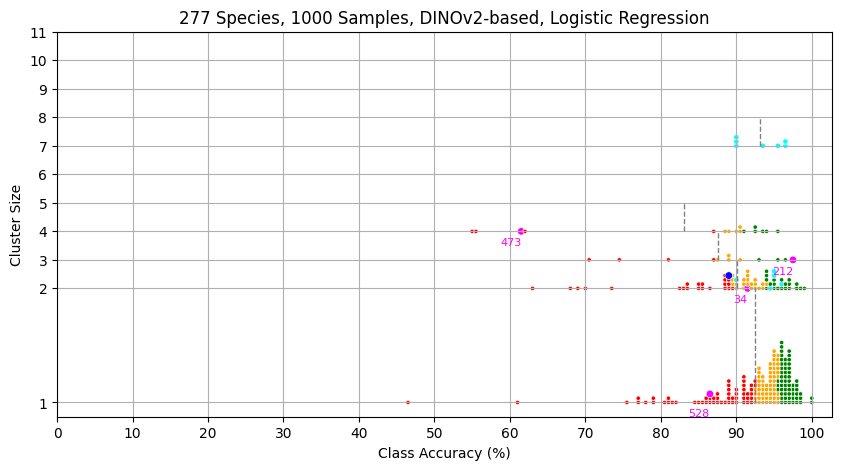

ClusterSize
1    93.96
2    91.97
3    90.29
4    85.66
7    93.29
Name: ClassAccuracy, dtype: float64
8.3


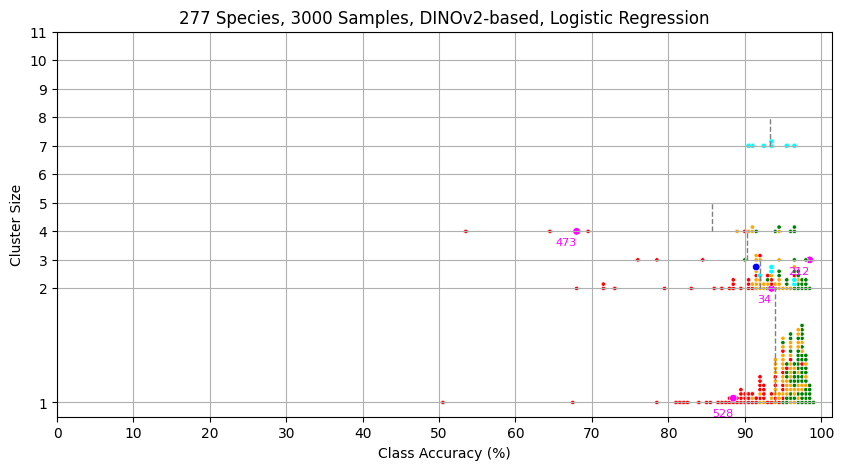

ClusterSize
1     91.22
2     87.06
3     84.30
4     85.97
5     83.93
6     89.78
10    84.80
11    88.09
Name: ClassAccuracy, dtype: float64
7.28


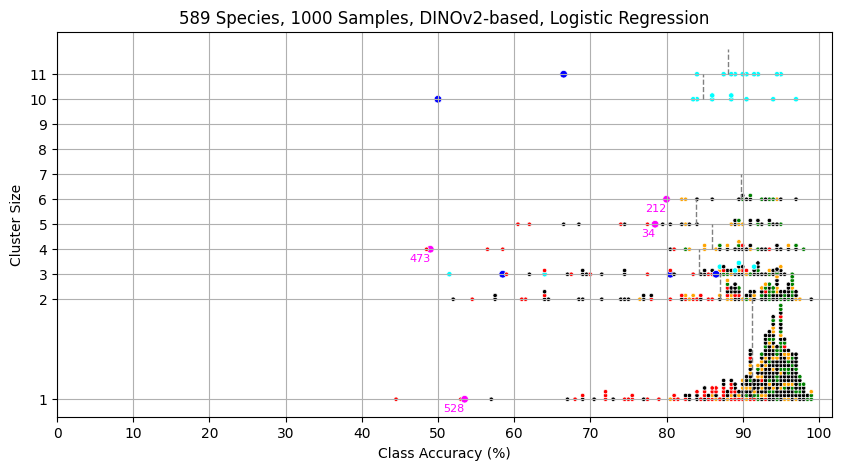

ClusterSize
1    73.72
2    67.88
3    64.04
4    52.09
7    70.50
Name: ClassAccuracy, dtype: float64
21.62


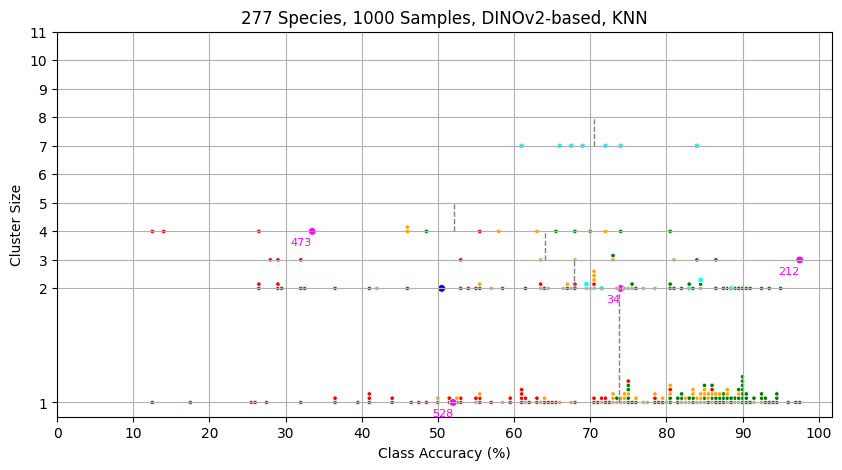

ClusterSize
1    77.99
2    72.44
3    68.92
4    59.41
7    74.00
Name: ClassAccuracy, dtype: float64
18.59


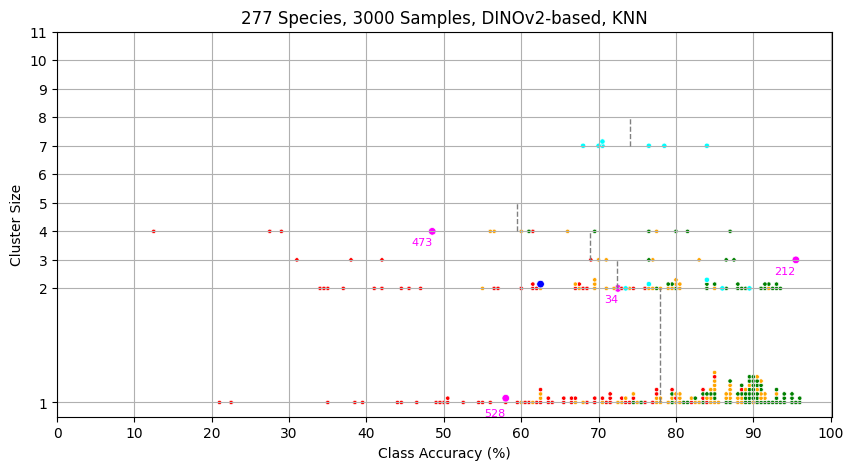

ClusterSize
1     70.78
2     64.19
3     56.72
4     55.65
5     50.73
6     66.50
10    57.50
11    62.05
Name: ClassAccuracy, dtype: float64
20.04


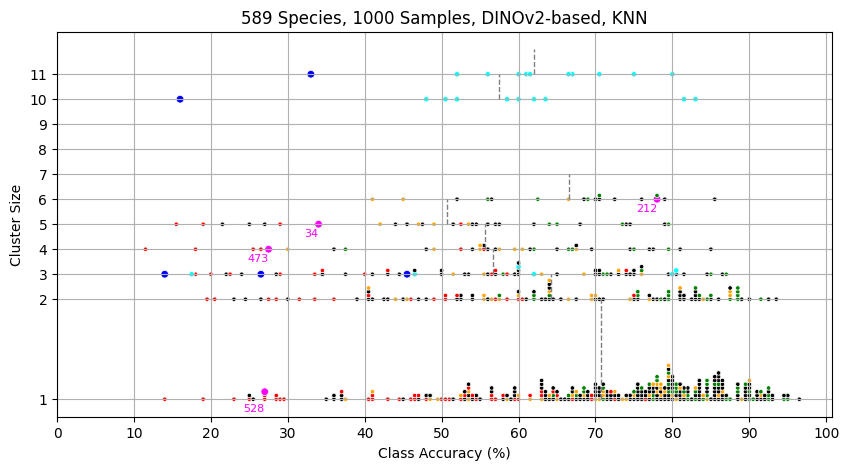

ClusterSize
1    70.59
2    65.83
3    67.21
4    48.31
7    62.21
Name: ClassAccuracy, dtype: float64
22.28


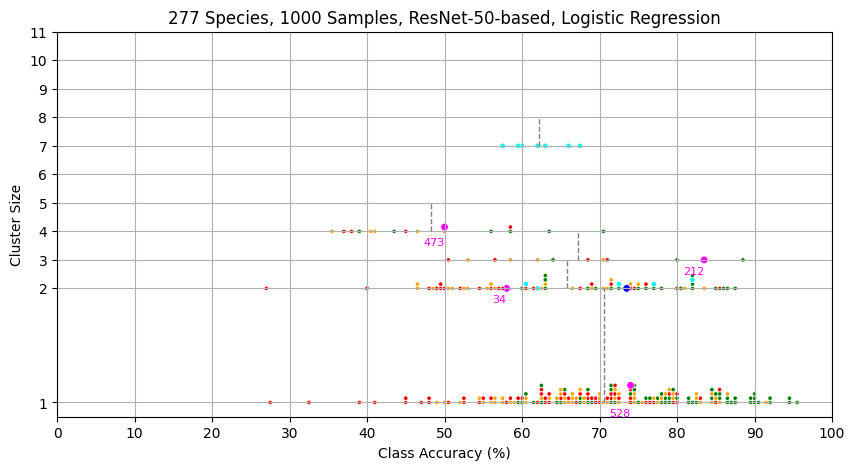

ClusterSize
1    73.12
2    68.39
3    69.96
4    52.19
7    62.50
Name: ClassAccuracy, dtype: float64
20.93


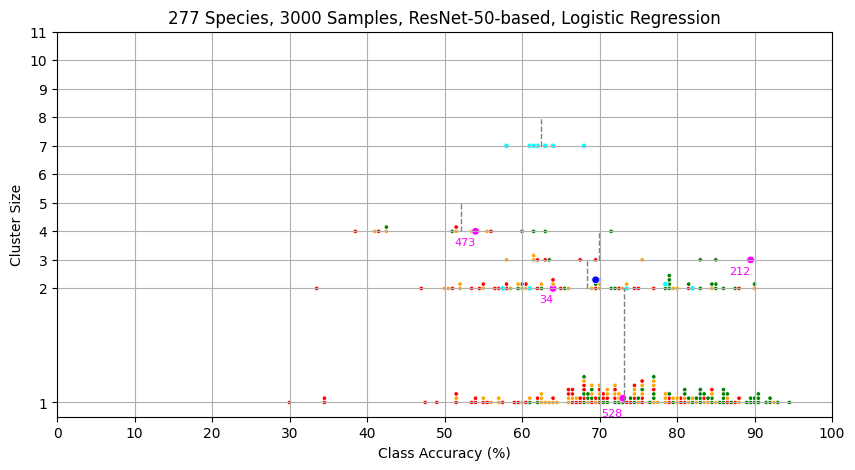

ClusterSize
1     65.08
2     63.62
3     55.94
4     51.51
5     49.07
6     55.11
10    55.80
11    54.95
Name: ClassAccuracy, dtype: float64
16.02


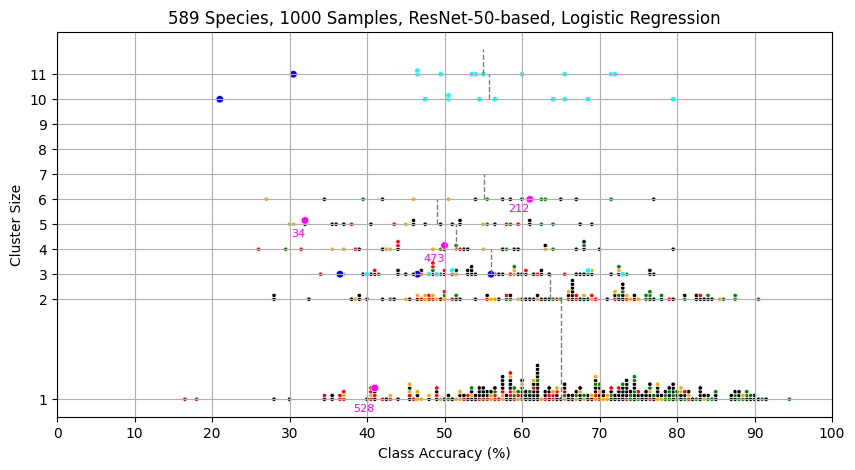

ClusterSize
1    43.40
2    38.88
3    44.96
4    21.56
7    28.71
Name: ClassAccuracy, dtype: float64
23.4


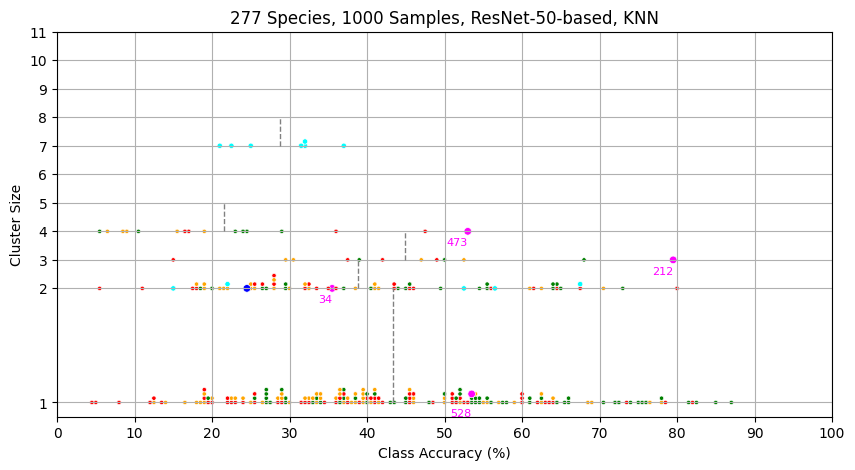

ClusterSize
1    48.88
2    43.44
3    49.62
4    25.47
7    32.43
Name: ClassAccuracy, dtype: float64
24.16


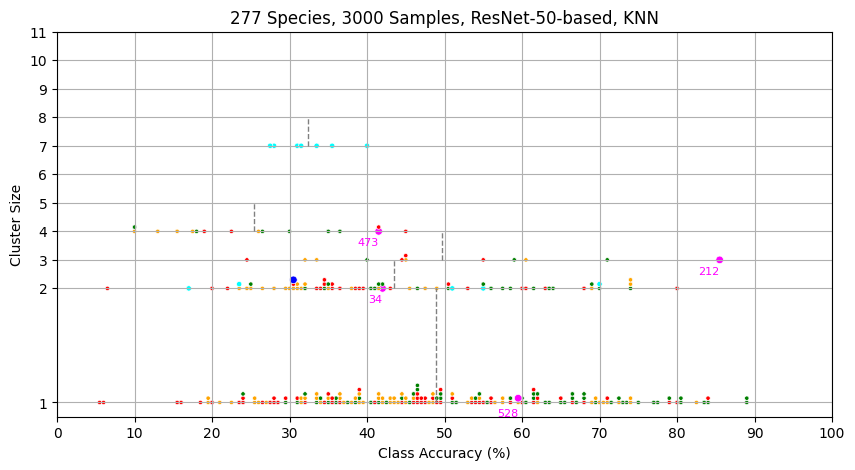

ClusterSize
1     36.53
2     38.13
3     29.09
4     23.93
5     21.27
6     28.31
10    32.25
11    26.14
Name: ClassAccuracy, dtype: float64
16.86


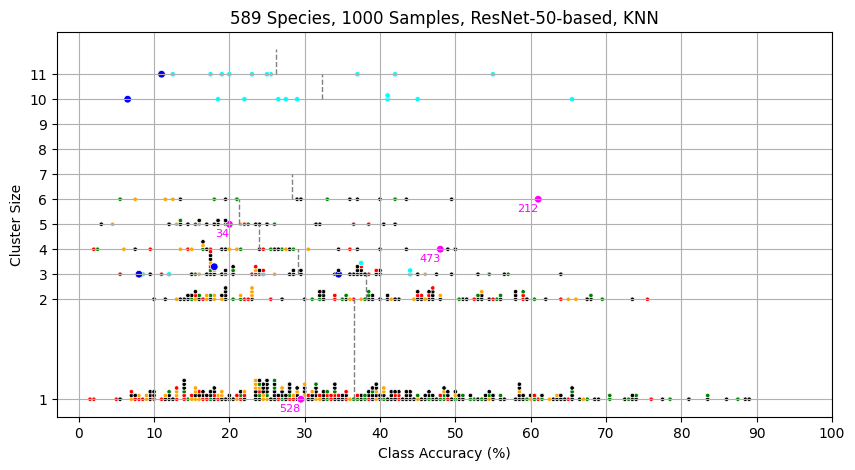

In [41]:
for fm in ['dino', 'resnet']:
    for clf in ['Linear Classifier', 'KNN']:
        
        df1 = create_label_overview(fm, clf, 277, 1000)
        df2 = create_label_overview(fm, clf, 277, 3000)
        df3 = create_label_overview(fm, clf, 589, 1000)

        scatter_labels(df1)
        scatter_labels(df2)
        scatter_labels(df3)

### Calculating mean difference of class accuracies between sample amounts

In [13]:
def find_biggest_changes(df1, df2, df3, df4):
    # Merge the dataframes on the 'Label' column
    merged_df = df1[['Label', 'ClassAccuracy']].merge(
        df2[['Label', 'ClassAccuracy']], on='Label', suffixes=('_df1', '_df2')
    ).merge(
        df3[['Label', 'ClassAccuracy']], on='Label'
    ).merge(
        df4[['Label', 'ClassAccuracy']], on='Label', suffixes=('_df3', '_df4')
    )

    # Calculate the maximum and minimum class accuracy for each label
    merged_df['max_accuracy'] = merged_df[['ClassAccuracy_df1', 'ClassAccuracy_df2', 'ClassAccuracy_df3', 'ClassAccuracy_df4']].max(axis=1)
    merged_df['min_accuracy'] = merged_df[['ClassAccuracy_df1', 'ClassAccuracy_df2', 'ClassAccuracy_df3', 'ClassAccuracy_df4']].min(axis=1)

    # Calculate the change in class accuracy
    merged_df['accuracy_change'] = merged_df['max_accuracy'] - merged_df['min_accuracy']

    # Sort the dataframe by the change in class accuracy
    sorted_df = merged_df.sort_values(by='accuracy_change', ascending=False)

    return sorted_df[['Label', 'accuracy_change', 'ClassAccuracy_df1', 'ClassAccuracy_df2', 'ClassAccuracy_df3', 'ClassAccuracy_df4']]

for fm in ['resnet', 'dino']:
    for clf in ['KNN', 'Linear Classifier']:
        df1 = create_label_overview(fm, clf, 277, 3000)
        df2 = create_label_overview(fm, clf, 277, 2000)
        df3 = create_label_overview(fm, clf, 277, 1000)
        df4 = create_label_overview(fm, clf, 277, 500)

        # Find the labels with the biggest changes in class accuracy
        biggest_changes_df = find_biggest_changes(df1, df2, df3, df4)
        print(fm, clf, round(biggest_changes_df['accuracy_change'].mean(), 6), '+-', round(biggest_changes_df['accuracy_change'].std(), 6))


resnet KNN 0.106625 +- 0.049463
resnet Linear Classifier 0.08704 +- 0.042761
dino KNN 0.098051 +- 0.053123
dino Linear Classifier 0.050162 +- 0.038153


In [14]:
# Create the label overview dataframes for the specified variants
df1 = create_label_overview('dino', 'Linear Classifier', 277, 1000)
df2 = create_label_overview('dino', 'Linear Classifier', 277, 3000)
df3 = create_label_overview('dino', 'Linear Classifier', 589, 1000)

# Merge the dataframes on the 'Label' column
merged_df = df1[['Label', 'ClassAccuracy']].merge(
    df2[['Label', 'ClassAccuracy']], on='Label', suffixes=('_277x1000', '_277x3000')
).merge(
    df3[['Label', 'ClassAccuracy']], on='Label'
)

# Calculate the maximum and minimum class accuracy for each label
merged_df['max_accuracy'] = merged_df[['ClassAccuracy_277x1000', 'ClassAccuracy_277x3000', 'ClassAccuracy']].max(axis=1)
merged_df['min_accuracy'] = merged_df[['ClassAccuracy_277x1000', 'ClassAccuracy_277x3000', 'ClassAccuracy']].min(axis=1)

# Calculate the change in class accuracy
merged_df['accuracy_change'] = merged_df['max_accuracy'] - merged_df['min_accuracy']

# Merge with the original dataframe to get the cluster size
merged_df = merged_df.merge(df1[['Label', 'ClusterSize']], on='Label')

# Get the three classes with the biggest accuracy changes for each cluster size
result = []
for cluster_size in range(1, 7):
    cluster_df = merged_df[merged_df['ClusterSize'] == cluster_size]
    top_3_classes = cluster_df.nlargest(3, 'accuracy_change')
    result.append(top_3_classes)

# Concatenate the results
final_result = pd.concat(result)
print(final_result[['Label', 'ClusterSize', 'accuracy_change']])

     Label  ClusterSize  accuracy_change
248    528            1            0.350
87     177            1            0.280
74     153            1            0.265
12      34            2            0.150
260    554            2            0.140
166    368            2            0.135
109    212            3            0.185
175    385            3            0.180
177    388            3            0.140
225    473            4            0.190
226    474            4            0.110
224    472            4            0.095


In [15]:
def analyze_misclassifications(df):
    misclassifications = {}
    
    for _, row in df.iterrows():
        label = row['Label']
        label_name = row['LabelName']
        genus = label_name.split(' ')[0]
        
        # Find all species in the same genus
        genus_species = [species for species in species_mapping.keys() if species.startswith(genus)]
        genus_labels = [species_mapping[species] for species in genus_species]
        
        # Parse the classification counts
        classification_counts = eval(row['ClassificationCounts'])
        
        total_wrong = sum(count for pred_label, count in classification_counts if pred_label != label)
        within_cluster = sum(count for pred_label, count in classification_counts if pred_label in genus_labels and pred_label != label)
        outside_cluster = total_wrong - within_cluster
        
        misclassifications[label] = {
            'total_wrong': total_wrong,
            'within_cluster': within_cluster,
            'outside_cluster': outside_cluster
        }
    
    return misclassifications


In [42]:
fm = 'dino'
#fm = 'resnet'
#clf = 'Linear Classifier'
clf = 'KNN'

df_277 = create_label_overview(fm, clf, 277, 1000)
df_589 = create_label_overview(fm, clf, 589, 1000)

In [43]:
pd.set_option('display.max_colwidth', None)
df = df_277[df_277['Label'].isin([528, 34, 212, 473])][['Label', 'LabelName','ClassAccuracy','ClassificationCounts']].drop_duplicates()
df

,Label,LabelName,ClassAccuracy,ClassificationCounts
12,34,Agriphila tristella,0.740,"[(34, 148), (33, 19), (169, 12), (168, 5), (167, 3), (123, 3), (430, 3)]"
109,212,Eilema complana,0.975,"[(212, 195)]"
225,473,Pieris mannii,0.335,"[(473, 67), (472, 29), (474, 18), (475, 9), (284, 8), (63, 7), (498, 7), (488, 5), (153, 5), (376, 4), (150, 3), (334, 3), (450, 3), (506, 3), (22, 3), (388, 2), (422, 2), (361, 2), (304, 2), (119, 2), (69, 2)]"
248,528,Speyeria aglaja,0.520,"[(528, 104), (335, 12), (381, 11), (388, 6), (387, 6), (73, 6), (82, 5), (343, 4), (554, 3), (385, 3), (361, 3), (369, 3), (450, 3), (119, 2), (472, 2), (506, 2), (422, 2), (488, 2), (274, 2), (304, 2), (380, 2)]"


In [44]:
misclassifications = analyze_misclassifications(df)

print(df['ClassificationCounts'].apply(lambda x: len(eval(x))))

# Print the results
for label, counts in misclassifications.items():
    label_name = list(species_mapping.keys())[list(species_mapping.values()).index(label)]
    print(f"Label: {label} ({label_name})")
    print(f"  Total misclassifications: {counts['total_wrong']}")
    print(f"  Within cluster: {counts['within_cluster']}")
    print(f"  Outside cluster: {counts['outside_cluster']}")
    print()

12      7
109     1
225    21
248    21
Name: ClassificationCounts, dtype: int64
Label: 34 (Agriphila tristella)
  Total misclassifications: 45
  Within cluster: 19
  Outside cluster: 26

Label: 212 (Eilema complana)
  Total misclassifications: 0
  Within cluster: 0
  Outside cluster: 0

Label: 473 (Pieris mannii)
  Total misclassifications: 119
  Within cluster: 56
  Outside cluster: 63

Label: 528 (Speyeria aglaja)
  Total misclassifications: 81
  Within cluster: 0
  Outside cluster: 81



In [45]:
df = df_589[df_589['Label'].isin([528, 34, 212, 473])][['Label', 'LabelName','ClassAccuracy','ClassificationCounts']].drop_duplicates()
df

,Label,LabelName,ClassAccuracy,ClassificationCounts
34,34,Agriphila tristella,0.340,"[(34, 68), (32, 55), (31, 19), (169, 13), (30, 10), (166, 9), (33, 4), (170, 3), (430, 3), (141, 2), (168, 2), (199, 2)]"
212,212,Eilema complana,0.780,"[(212, 156), (211, 30), (215, 6)]"
473,473,Pieris mannii,0.275,"[(473, 55), (472, 20), (474, 16), (63, 13), (475, 11), (346, 9), (283, 6), (154, 6), (376, 4), (69, 4), (284, 4), (150, 4), (106, 4), (488, 3), (334, 2), (295, 2), (128, 2), (99, 2), (8, 2), (422, 2), (511, 2), (506, 2)]"
528,528,Speyeria aglaja,0.270,"[(528, 54), (271, 19), (99, 18), (272, 16), (96, 12), (452, 8), (154, 6), (97, 5), (95, 5), (304, 4), (381, 4), (73, 4), (98, 3), (82, 3), (67, 2), (150, 2), (388, 2), (387, 2), (382, 2), (343, 2), (335, 2), (305, 2), (234, 2), (233, 2)]"


In [46]:

# Analyze misclassifications for df
misclassifications = analyze_misclassifications(df)

print(df['ClassificationCounts'].apply(lambda x: len(eval(x))))

# Print the results
for label, counts in misclassifications.items():
    label_name = list(species_mapping.keys())[list(species_mapping.values()).index(label)]
    print(f"Label: {label} ({label_name})")
    print(f"  Total misclassifications: {counts['total_wrong']}")
    print(f"  Within cluster: {counts['within_cluster']}")
    print(f"  Outside cluster: {counts['outside_cluster']}")
    print()



34     12
212     3
473    22
528    24
Name: ClassificationCounts, dtype: int64
Label: 34 (Agriphila tristella)
  Total misclassifications: 122
  Within cluster: 88
  Outside cluster: 34

Label: 212 (Eilema complana)
  Total misclassifications: 36
  Within cluster: 36
  Outside cluster: 0

Label: 473 (Pieris mannii)
  Total misclassifications: 120
  Within cluster: 47
  Outside cluster: 73

Label: 528 (Speyeria aglaja)
  Total misclassifications: 127
  Within cluster: 0
  Outside cluster: 127



In [23]:
print(get_gbifids_for_class(34, confidences_csv, 5))
print(get_gbifids_for_class(32, confidences_csv, 5))
print(get_gbifids_for_class(166, confidences_csv, 4))

[2837402514, 1969109923, 3722770293, 1959405711, 3717772501]
[4156302564, 4891403354, 3731065065, 4881198101, 3727856362]
[4056500261, 4887110750, 4890526603, 4408578708]


Agriphila tristella 3717772501_30399870.jpg


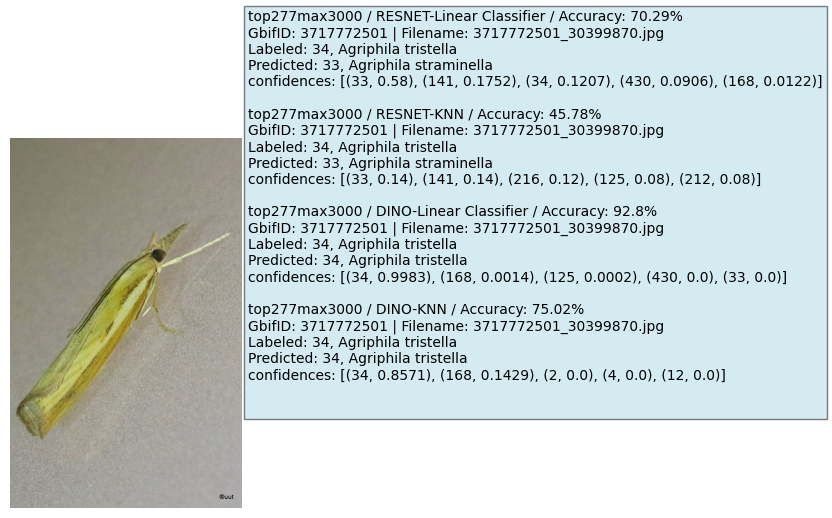

Agriphila selasella 4881198101_86728263.jpg


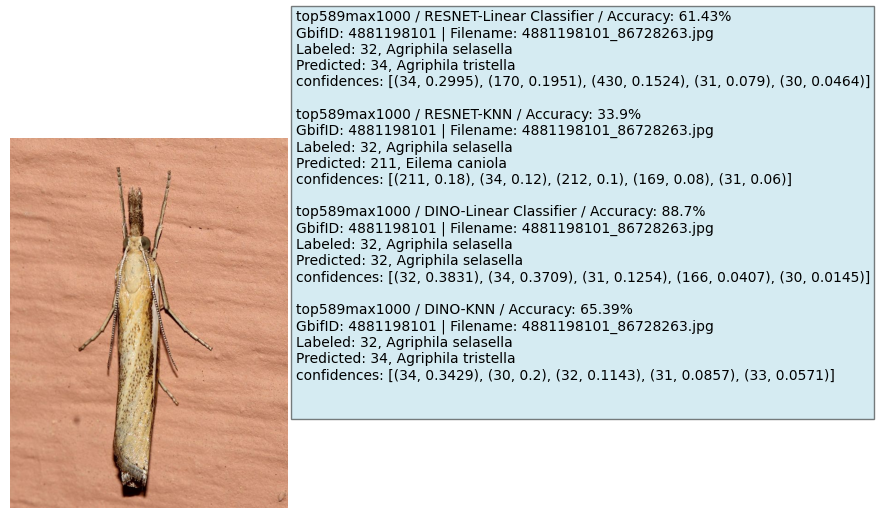

Crambidae indet. 4890526603_54812633.jpg


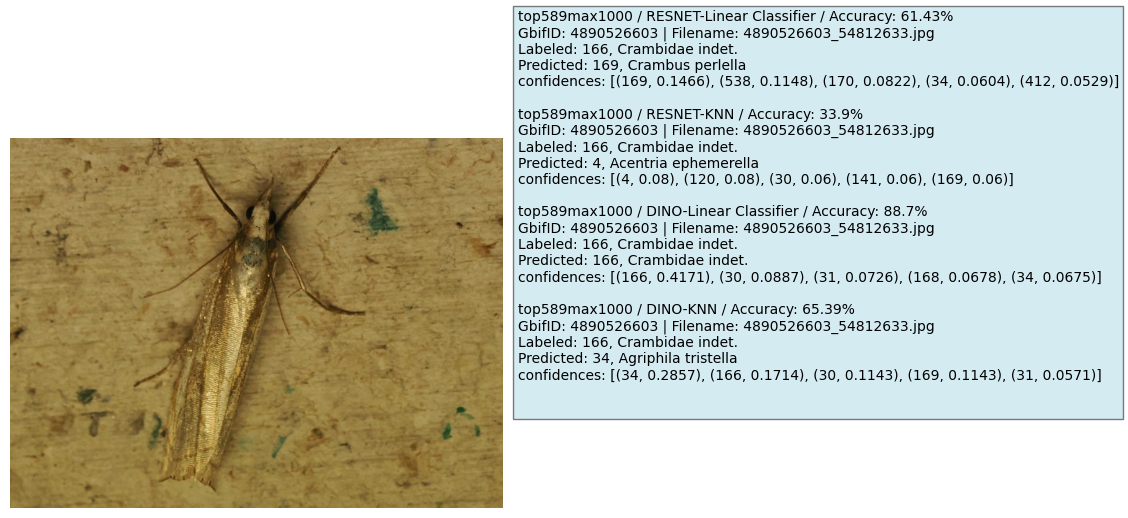

In [24]:
show_sample_by_id(3717772501, confidences_csv)
show_sample_by_id(4881198101, confidences_csv)
show_sample_by_id(4890526603, confidences_csv)

In [25]:
# import ast
# import numpy as np
# df = filtered_df_dino_specific_ds.copy()


# # Step 1: Aggregate all confidences per label
# label_confidences = {}

# for label, conf_str in zip(df['Label'], df['Confidence']):
#     confidences_list = ast.literal_eval(conf_str)  # Convert string to list of tuples

#     if label not in label_confidences:
#         label_confidences[label] = {}

#     # Sum confidence values for each class
#     for conf_label, confidence in confidences_list:
#         if conf_label not in label_confidences[label]:
#             label_confidences[label][conf_label] = []
#         label_confidences[label][conf_label].append(confidence)

# # Step 2: Compute per-label averaged confidence lists
# averaged_confidences = {}

# for label, conf_dict in label_confidences.items():
#     averaged_confidences[label] = {
#         conf_label: round(np.mean(conf_list), 4) for conf_label, conf_list in conf_dict.items()
#     }

# # Step 3: Store top-5 highest average confidence values per label
# top5_averaged_confidences = {
#     label: sorted(conf_dict.items(), key=lambda x: x[1], reverse=True)[:5]
#     for label, conf_dict in averaged_confidences.items()
# }

# # Step 4: Assign the same top-5 confidences to all samples of the same label
# df['AveragedConfidence'] = df['Label'].apply(lambda label: str(top5_averaged_confidences[label]))

# # Display result
# df[df['Label'] == 256][['Label', 'PredictedLabel','Confidence','AveragedConfidence']]





In [26]:

# Filter the dataframe to include only the worst performing classes
worst_classes_df = filtered_df_dino_specific_ds[filtered_df_dino_specific_ds['Label'].isin(worst_performing_classes.index)]

# Extract the true labels and predicted labels for the worst performing classes
true_labels_worst = worst_classes_df['Label']
predicted_labels_worst = worst_classes_df['PredictedLabel']

# Create the confusion matrix for the worst performing classes
conf_matrix_worst = confusion_matrix(true_labels_worst, predicted_labels_worst, labels=worst_performing_classes.index)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_worst, annot=True, fmt='d', cmap='Blues', xticklabels=worst_performing_classes.index, yticklabels=worst_performing_classes.index)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for the 20 Worst Performing Classes')
plt.show()

NameError: name 'filtered_df_dino_specific_ds' is not defined

In [ ]:
# Step 1: Identify the classes with the lowest class accuracy
lowest_accuracy_classes = df.nsmallest(20, 'ClassAccuracy')['Label']

# Step 2: Count the number of unique classes each of these classes is confused with
confusion_counts = {}
for label in lowest_accuracy_classes:
    confused_classes = set()
    for pair in confusion_pairs:
        if pair[0] == label:
            confused_classes.add(pair[1])
        elif pair[1] == label:
            confused_classes.add(pair[0])
    confusion_counts[label] = len(confused_classes)

# Step 3: Calculate the average number of unique classes they are confused with
average_confusion_count = sum(confusion_counts.values()) / len(confusion_counts)

print(f"The average amount of classes the classes with the lowest class accuracy are confused with: {average_confusion_count}")

The average amount of classes the classes with the lowest class accuracy are confused with: 15.35


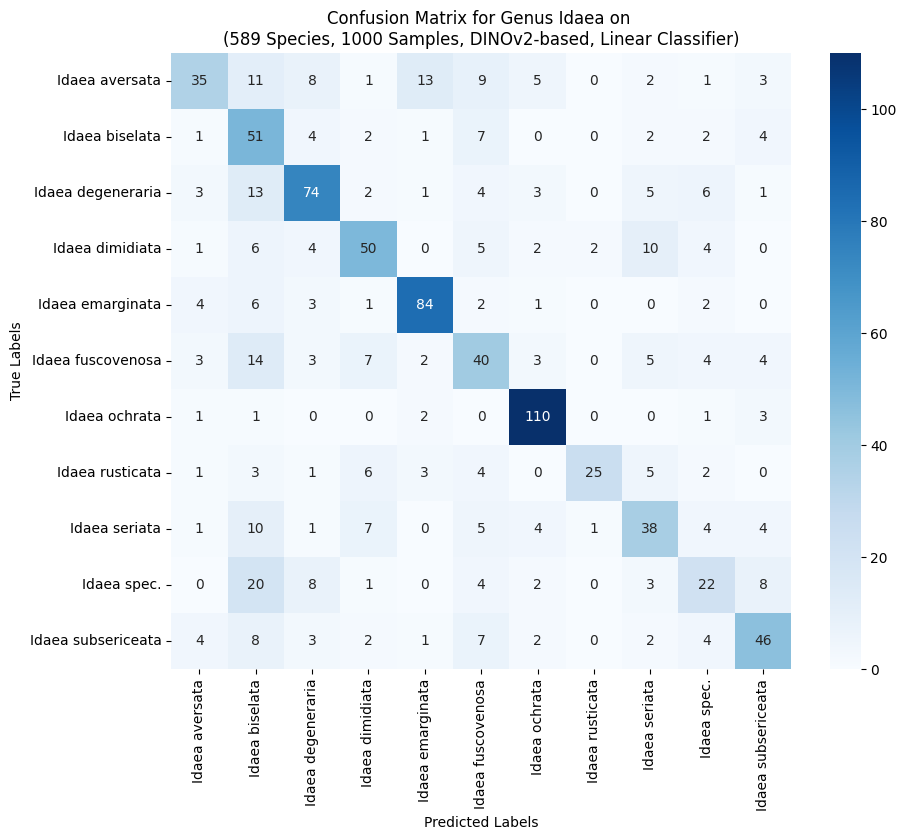

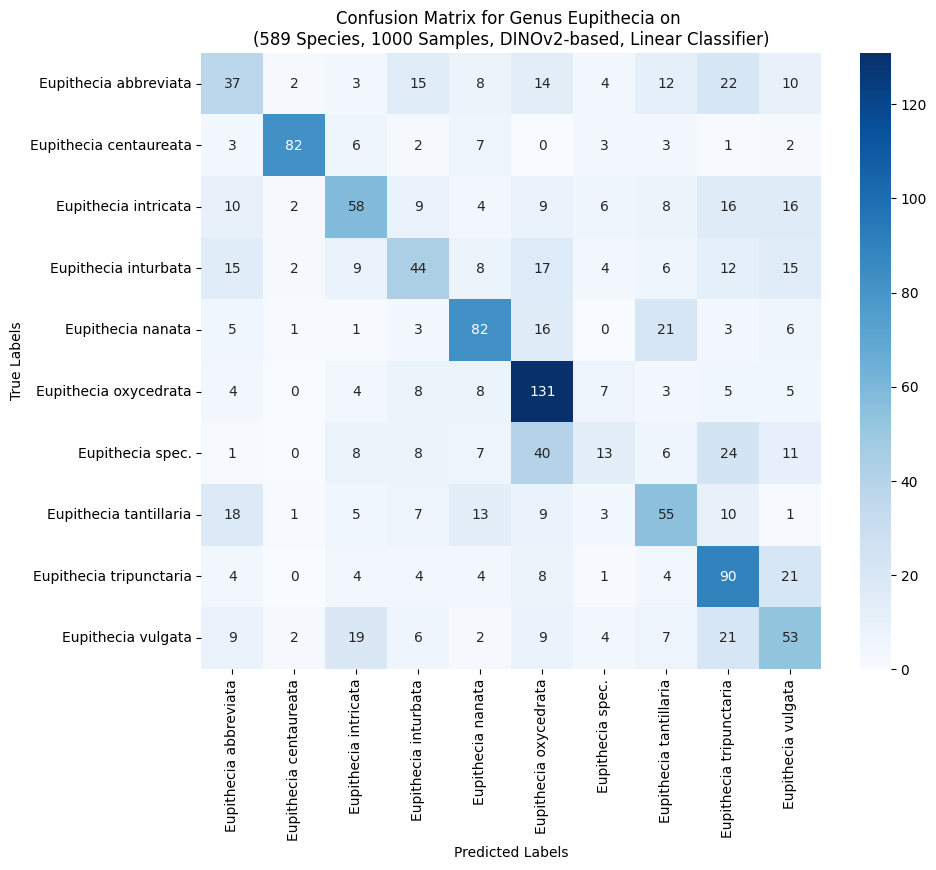

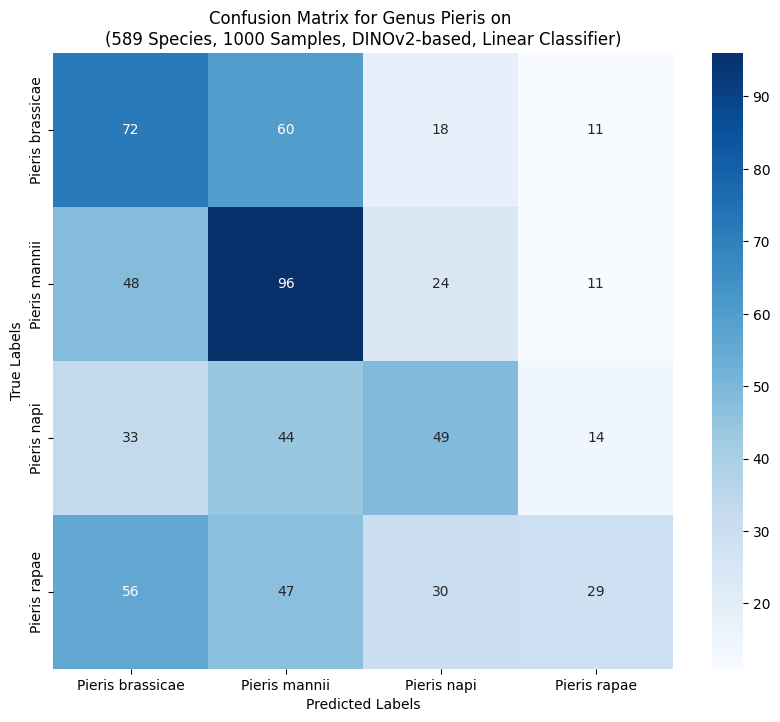

NameError: name 'I' is not defined

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot confusion matrix for a given genus
def plot_confusion_matrix_for_genus(genus, confidences_csv, species_mapping):
    # Filter the dataframe for the specific genus
    genus_species = [species for species in species_mapping.keys() if species.startswith(genus)]
    genus_labels = [species_mapping[species] for species in genus_species]
    filtered_df = confidences_csv[confidences_csv['Label'].isin(genus_labels) | confidences_csv['PredictedLabel'].isin(genus_labels)]
    
    # Extract the true labels and predicted labels
    true_labels = filtered_df['Label']
    predicted_labels = filtered_df['PredictedLabel']
    
    # Create the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=genus_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genus_species, yticklabels=genus_species)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Genus {genus} on \n(589 Species, 1000 Samples, DINOv2-based, Linear Classifier)')
    plt.show()

# Iterate through each genus and plot the confusion matrix
genera_with_more_than_one = ['Idaea', 'Eupithecia', 'Pieris']
df_for_matrix = confidences_csv[(confidences_csv['Species'] == 589) & (confidences_csv['Samples'] == 1000) & (confidences_csv['FoundationalModel'] == 'resnet') & (confidences_csv['Model'] == 'KNN')]

for genus in genera_with_more_than_one:
    plot_confusion_matrix_for_genus(genus, df_for_matrix, species_mapping)
I

In [ ]:
df = create_label_overview(fm, clf, 589, 1000)
df

,Species,Samples,FoundationalModel,Model,Label,LabelName,ClassAccuracy,ClassificationCounts,ClusterSize,AverageTop1Confidence,AverageTop1ConfidenceCorrect,AverageTop1ConfidenceIncorrect
0,589,1000,resnet,KNN,0,Abraxas grossulariata,0.680,"[(0, 136), (58, 8), (450, 5), (491, 3), (79, 2...",2,0.4580,0.6062,0.1431
1,589,1000,resnet,KNN,1,Abraxas sylvata,0.530,"[(1, 106), (0, 8), (355, 4), (350, 4), (73, 3)...",2,0.2469,0.3455,0.1357
2,589,1000,resnet,KNN,2,Abrostola triplasia,0.210,"[(2, 42), (530, 6), (293, 5), (12, 5), (46, 5)...",1,0.1153,0.1381,0.1092
3,589,1000,resnet,KNN,3,Acasis viretata,0.440,"[(3, 88), (257, 6), (218, 5), (139, 3), (313, ...",1,0.1844,0.2820,0.1077
4,589,1000,resnet,KNN,4,Acentria ephemerella,0.705,"[(4, 141), (349, 4), (126, 3), (400, 3), (211,...",1,0.2965,0.3735,0.1125
...,...,...,...,...,...,...,...,...,...,...,...,...
584,589,1000,resnet,KNN,584,Ypsolopha scabrella,0.585,"[(584, 117), (152, 13), (483, 10), (477, 7), (...",1,0.2714,0.3720,0.1296
585,589,1000,resnet,KNN,585,Zeiraphera isertana,0.240,"[(585, 48), (60, 10), (477, 8), (359, 6), (532...",1,0.1354,0.1967,0.1161
586,589,1000,resnet,KNN,586,Zerynthia rumina,0.640,"[(586, 128), (305, 8), (448, 6), (97, 4), (220...",1,0.3731,0.4806,0.1819
587,589,1000,resnet,KNN,587,Zeuzera pyrina,0.690,"[(587, 138), (582, 4), (9, 4), (238, 4), (0, 2...",1,0.3728,0.4830,0.1274
